In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Search dirrectory and create one big df

In [2]:
import os
datadir = "/home/sywi/Documents/AirPolutionPrediction/hourly_pred/Data/"
fulldir = os.path.join(os.getcwd(), datadir)
allfiles = os.listdir(fulldir)
allfiles.sort(key= lambda x: x.split('_')[0])
kras_df = pd.DataFrame()

for filename in reversed(allfiles):
    name = 'Data/' + filename
    temp_df = pd.read_csv(name, sep=";", index_col='Date')
    temp_df.drop([temp_df.columns[1]],axis=1, inplace=True)
    kras_df = kras_df.append(temp_df)

kras_df.info()
kras_df.to_csv("AlKras.csv", header=True, index=True)

<class 'pandas.core.frame.DataFrame'>
Index: 43819 entries, 2018-01-01 01:00 to 2015-01-01 00:00
Data columns (total 1 columns):
AlKras    43313 non-null float64
dtypes: float64(1)
memory usage: 684.7+ KB


In [3]:
kras_df = pd.read_csv("AlKras.csv", index_col='Date')
del kras_df.index.name
print('data type: ', type(kras_df))
print('Number of NaN = ', np.sum(np.isnan(kras_df.iloc[:,0])))
kras_df.head()

data type:  <class 'pandas.core.frame.DataFrame'>
Number of NaN =  506


,AlKras
2018-01-01 01:00,26.3
2018-01-01 02:00,59.1
2018-01-01 03:00,35.9
2018-01-01 04:00,39.6
2018-01-01 05:00,39.6


# Dilling with missing data

## Impute values from previous years

In [4]:
def prev_year(date):
    splitted_list = date.split('-')
    splitted_list[0] = str(int(splitted_list[0]) - 1)
    return '-'.join(splitted_list)

def impute_prev_year(date):
    prev_date = prev_year(date)
    try:
        if not np.isnan(kras_df.loc[prev_date,kras_df.columns[0]]):
            return kras_df.loc[prev_date,kras_df.columns[0]]
        else:
            impute_prev_year(prev_date)
    except:
        return np.nan

In [5]:
for index, missing_value in kras_df[kras_df[kras_df.columns[0]].isna() == True].iterrows():
    kras_df.loc[index,kras_df.columns[0]] = impute_prev_year(index)
print('Number of NaN = ', np.sum(np.isnan(kras_df.iloc[:,0])))

Number of NaN =  90


# Moving average vs normal data
moving average also handles missing values

In [6]:
avg_kras_df = kras_df.rolling(168, min_periods=1).mean() #there is 168 hours in one week
avg_kras_df = round(avg_kras_df, 3)
print('avg shape:', avg_kras_df.shape)
print('Number of NaN = ', np.sum(np.isnan(avg_kras_df.iloc[:,0])))

avg shape: (43819, 1)
Number of NaN =  0


Text(0.5, 1.0, 'normal')

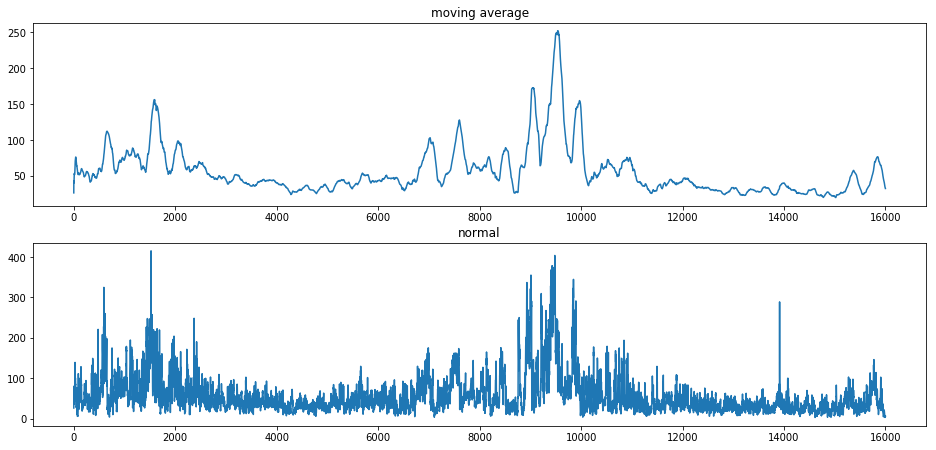

In [7]:
fig = plt.figure(figsize=(16,2))
plt.subplots_adjust(bottom=0.2, top=3, hspace = 0.2)

ax = fig.add_subplot(211)
ax.plot(avg_kras_df.iloc[:16000,0].values)
ax.set_title('moving average')


ax = fig.add_subplot(212)
ax.plot(kras_df.iloc[:16000,0].values)
ax.set_title('normal')

# plotting few days

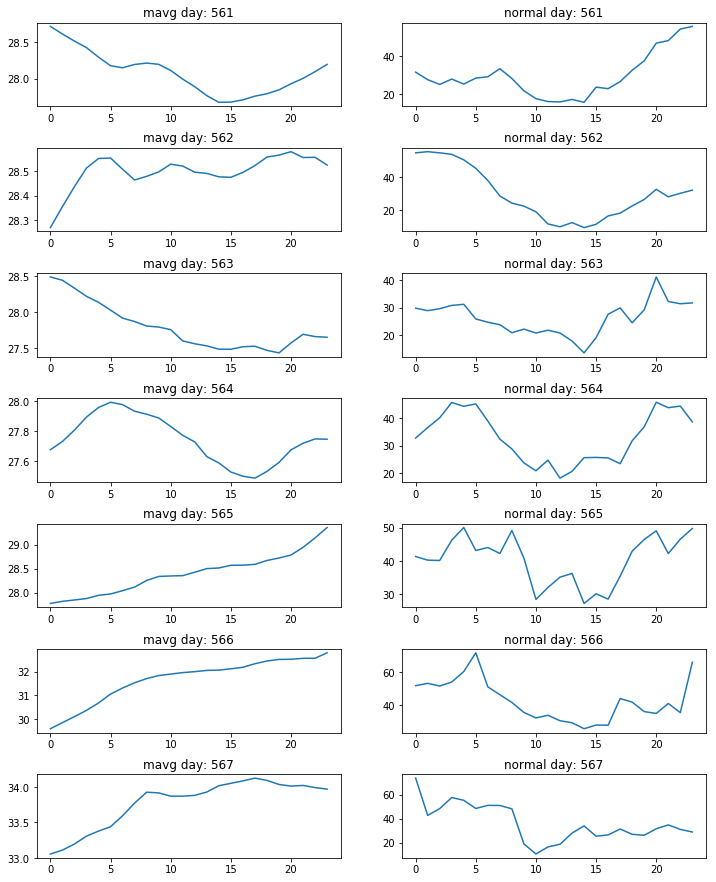

In [8]:
#inital values
n_days = 7
first_day = 560
period_h = 24

fig = plt.figure(figsize=(12,4))
plt.subplots_adjust(bottom=0.1, top=3, hspace = 0.5)
#plt.tight_layout(rect=(0, 0, 2, 2))

for i in range(n_days):
    ax = fig.add_subplot(n_days,2,2*i+1)
    ax.plot(avg_kras_df[period_h*(i+first_day):period_h*(i+1+first_day)].values)
    ax.set_title('mavg day: ' + str(i+1+first_day))
    #ax.set_ylim(bottom=avg_kras_df.values.min(), top=avg_kras_df.values.max())
    
    ax = fig.add_subplot(n_days,2,2*(i+1))
    ax.plot(kras_df[period_h*(i+first_day):period_h*(i+1+first_day)].values)
    ax.set_title('normal day: ' + str(i+1+first_day))
    #ax.set_ylim(bottom=avg_kras_df.values.min(), top=avg_kras_df.values.max())

# Save data

In [9]:
avg_kras_df.to_csv("AvgAlKras.csv", header=True, index=True)